# Training Variational Autoencoder

## Overview

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import muse.supplier as spr
import muse.processor2 as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

1. Load and sort music by instruments
2. Remove 
3. Remove
4. Spliting into training and validation sets

In [2]:
### ===== Hyperparameters ===== ###

mdl_name1 = 'vae43_melody'
mdl_name2 = 'vae43_offset'
instrument = 'Piano'
filepath = "./../input/beeth/"
song_len = 200*1
stride = 200
epochs = 1000
learning_rate = 0.001
device = trn.get_device()

In [3]:
### ===== Data Preprocessing ===== ###

seed_load = np.random.randint(0,999999999)
seed_load = 592643464 # set to seed that works

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.get_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short

X_train_melody, X_val_melody, X_train_offset, X_val_offset = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load, process='center')
X_train_melody, X_val_melody = pcr.batchify(X_train_melody), pcr.batchify(X_val_melody) # reshape and turn into tensor
X_train_offset, X_val_offset = pcr.batchify(X_train_offset), pcr.batchify(X_val_offset) # reshape and turn into tensor

classes = len(set(Corpus)) # get number of unique keys

## Training the Melody



In [4]:
### ===== Training Loop ===== ###

def train_model(model, device, mdl_name,
                train_loader, val_loader, 
                lr, seeds, epochs, 
                eepoch=10, epoch_start=0,
                lda0=1, lda1=1, lda2=1,
                train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                stdlog=[],
                save=True, load=False, mdl_load=''):
    
    # get loss function 
    criterion1 = nn.MSELoss()
    criterion2 = nn.CrossEntropyLoss()
    
    # get optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # load model
    if load:
        model, train_losses, val_losses, train_acc, val_acc, epoch_start, seeds = trn.load_model(mdl_load, model, device)
        
    # set parameters
    if type(lda0) != np.ndarray: lda0 = np.ones(epochs)*lda0
    if type(lda1) != np.ndarray: lda1 = np.ones(epochs)*lda1
    if type(lda2) != np.ndarray: lda2 = np.ones(epochs)*lda2

    # training loop
    for epoch in range(epoch_start, epoch_start+epochs):
        
        # set std
        e = epoch-epoch_start
        if stdlog != []:
            model.std = stdlog[e]

        # train model
        model.train()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            recons, mu, logvar, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
            
        train_losses.append(np.mean(batch_losses))
        train_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))

        # validate model
        model.eval()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(val_loader):
            batch_data = batch_data.to(device)
            recons, mu, logvar, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            batch_losses.append(l.item())
            
        val_losses.append(np.mean(batch_losses))
        val_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))
        
        # print loss, accuracy
        if epoch % eepoch == 0:
            
            print('Epoch: {}\t TLoss: {:.6f}\t VLoss: {:.6f}\t TACC: {:.2f}\t VACC: {:.2f}'\
                  .format(epoch, train_losses[-1], val_losses[-1], train_acc[-1], val_acc[-1]))
   
        # save model
        if save:
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
              'train_losses': train_losses, 'val_losses':val_losses, 
              'train_acc':train_acc, 'val_acc':val_acc, 'seeds': seeds}
            torch.save(state, './models/'+mdl_name+'.pt')
        
    return model, train_losses, val_losses, train_acc, val_acc

Epoch: 0	 TLoss: 442.068824	 VLoss: 257.664942	 TACC: 0.03	 VACC: 0.01
Epoch: 100	 TLoss: 141.440205	 VLoss: 179.078639	 TACC: 0.04	 VACC: 0.03
Epoch: 200	 TLoss: 131.844584	 VLoss: 175.548331	 TACC: 0.04	 VACC: 0.03
Epoch: 300	 TLoss: 123.386056	 VLoss: 187.725447	 TACC: 0.04	 VACC: 0.03
Epoch: 400	 TLoss: 120.837022	 VLoss: 197.420845	 TACC: 0.07	 VACC: 0.02
Epoch: 500	 TLoss: 117.979303	 VLoss: 202.505730	 TACC: 0.03	 VACC: 0.04
Epoch: 600	 TLoss: 116.382242	 VLoss: 209.507536	 TACC: 0.04	 VACC: 0.03
Epoch: 700	 TLoss: 114.693693	 VLoss: 205.253220	 TACC: 0.04	 VACC: 0.03
Epoch: 800	 TLoss: 114.618524	 VLoss: 213.508427	 TACC: 0.03	 VACC: 0.02
Epoch: 900	 TLoss: 113.277270	 VLoss: 207.919991	 TACC: 0.04	 VACC: 0.02


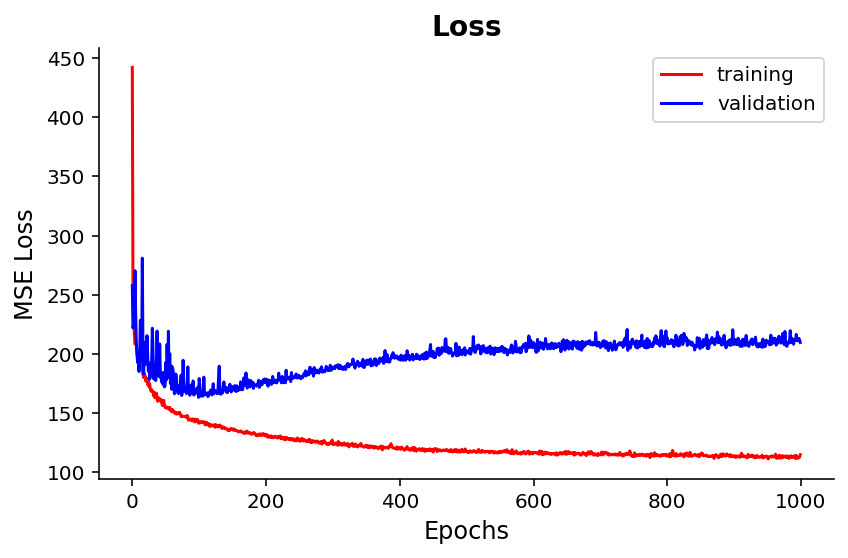

<Figure size 432x288 with 0 Axes>

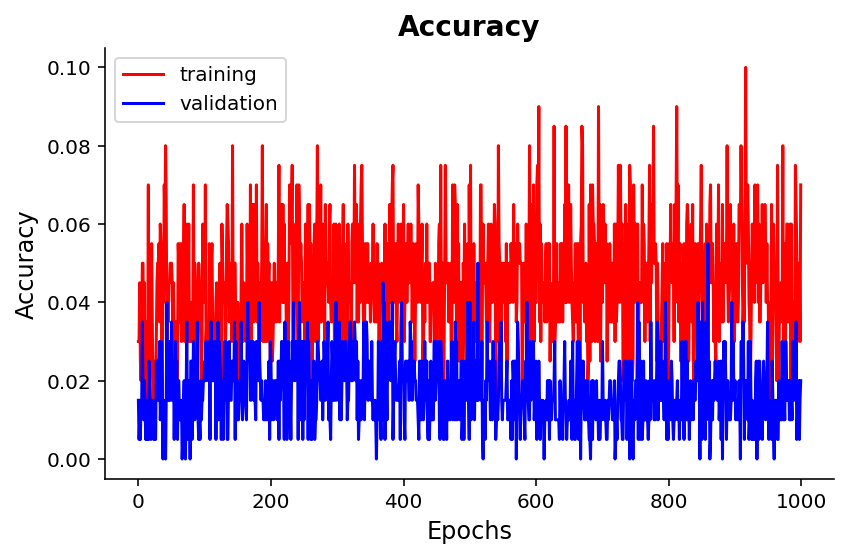

<Figure size 432x288 with 0 Axes>

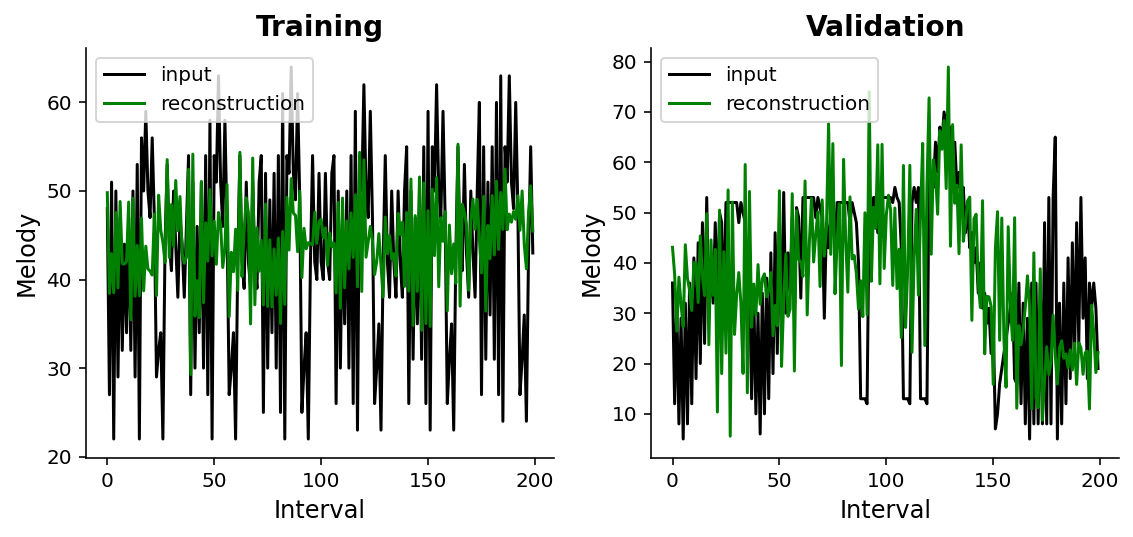

<Figure size 432x288 with 0 Axes>

In [14]:
### ===== Train Model for Melody using MSELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name1+'_MSE',
               X_train_melody, X_val_melody,
               learning_rate, [seed_load, seed_model], 1000,
               eepoch=100,
               lda0=1, lda1=0, lda2=1,
               train_losses=[], val_losses=[], train_acc=[], val_acc=[],
               save=True, load=False)
    
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/{}_MSE_loss.png'.format(mdl_name1), ylabel='MSE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/{}_MSE_acc.png'.format(mdl_name1), ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train_melody[0], X_val_melody[0], './figures/{}_MSE_sample.png'.format(mdl_name1))
    
except KeyboardInterrupt:
    print('Training terminated.')

Epoch: 0	 TLoss: 284.128474	 VLoss: 374.309147	 TACC: 0.03	 VACC: 0.00
Epoch: 100	 TLoss: 251.296239	 VLoss: 295.143121	 TACC: 0.02	 VACC: 0.01
Epoch: 200	 TLoss: 629.581650	 VLoss: 704.446963	 TACC: 0.01	 VACC: 0.02
Epoch: 300	 TLoss: 1579.782302	 VLoss: 1753.600242	 TACC: 0.02	 VACC: 0.01
Epoch: 400	 TLoss: 3965.732294	 VLoss: 4371.688011	 TACC: 0.01	 VACC: 0.04
Epoch: 500	 TLoss: 9952.252322	 VLoss: 10947.049910	 TACC: 0.01	 VACC: 0.03
Epoch: 600	 TLoss: 25046.702125	 VLoss: 27464.821800	 TACC: 0.01	 VACC: 0.03
Epoch: 700	 TLoss: 63030.193974	 VLoss: 68873.331367	 TACC: 0.01	 VACC: 0.02
Epoch: 800	 TLoss: 158222.545992	 VLoss: 172732.585615	 TACC: 0.01	 VACC: 0.01
Epoch: 900	 TLoss: 397697.584936	 VLoss: 433419.985402	 TACC: 0.01	 VACC: 0.01
Epoch: 1000	 TLoss: 991161.155306	 VLoss: 1076950.344530	 TACC: 0.01	 VACC: 0.02
Epoch: 1100	 TLoss: 990571.203772	 VLoss: 1075907.427501	 TACC: 0.01	 VACC: 0.02
Epoch: 1200	 TLoss: 990341.360265	 VLoss: 1075013.378610	 TACC: 0.01	 VACC: 0.02
Ep

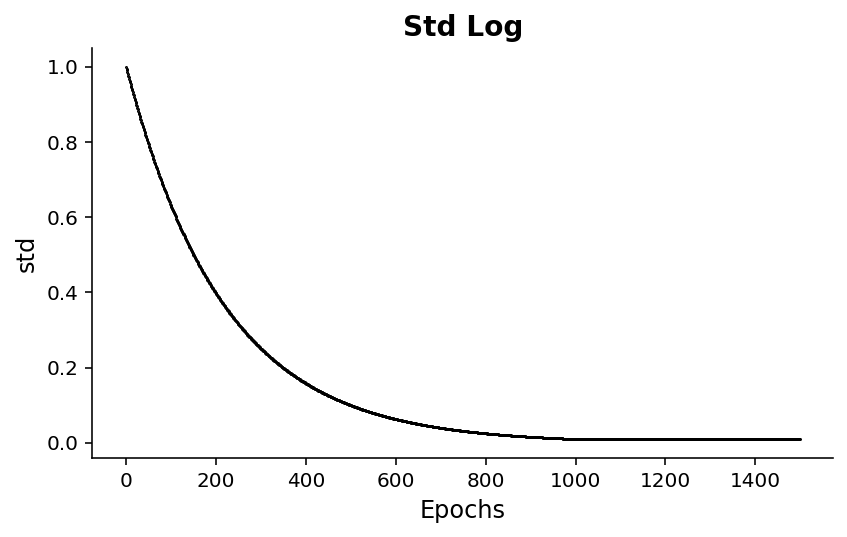

<Figure size 432x288 with 0 Axes>

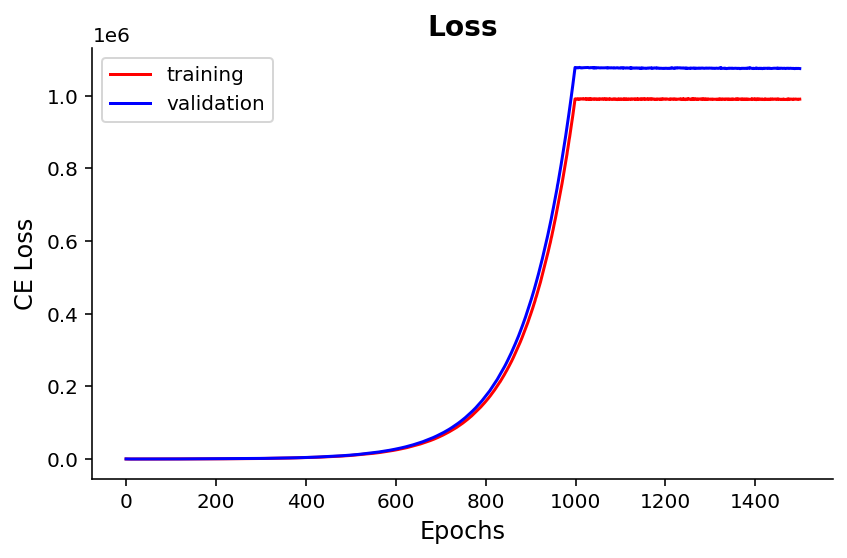

<Figure size 432x288 with 0 Axes>

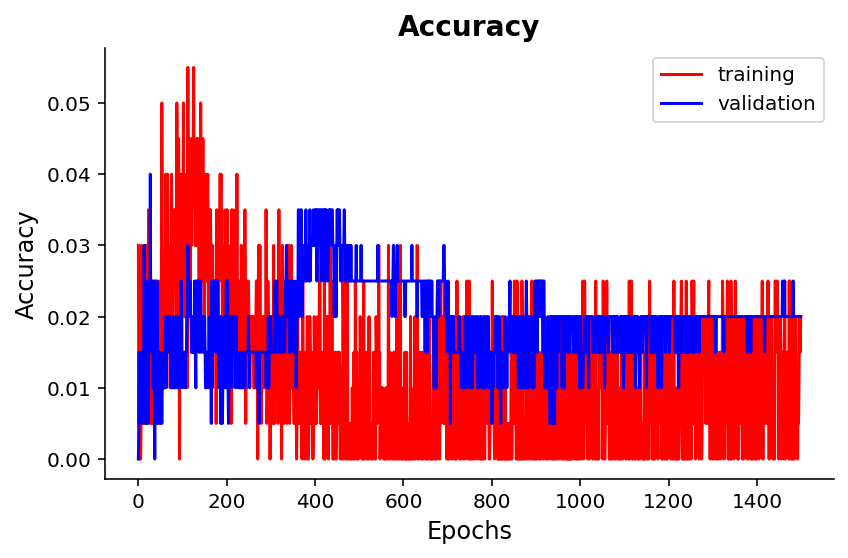

<Figure size 432x288 with 0 Axes>

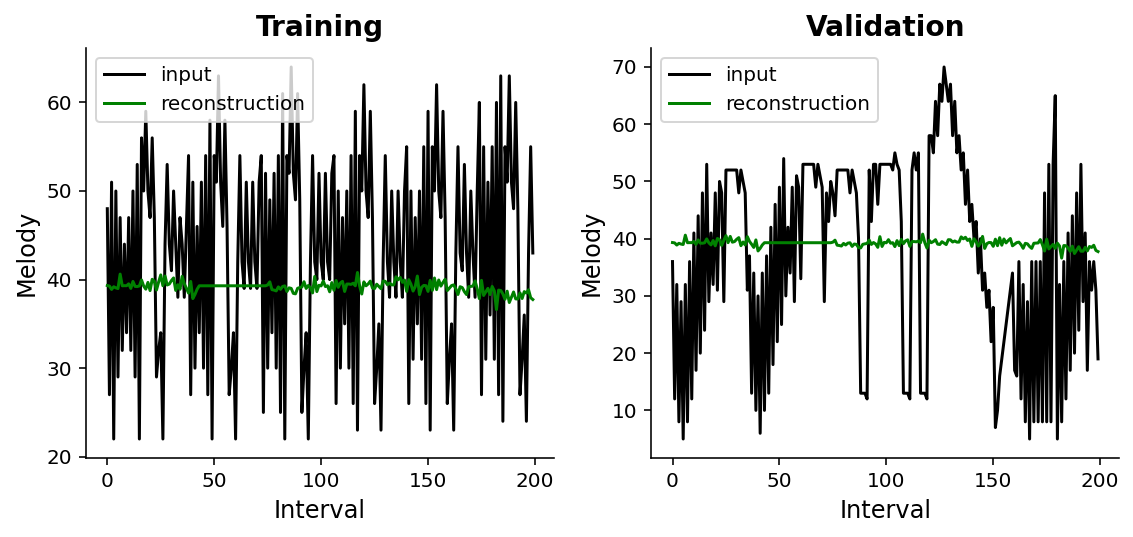

<Figure size 432x288 with 0 Axes>

In [9]:
### ===== Train Model for Melody using CELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    stdlog = np.append(np.geomspace(1, 0.01, 1000), np.ones(500)*0.01)
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name1+'_CE',
                   X_train_melody, X_val_melody,
                   learning_rate, [seed_load, seed_model], 1500,
                   eepoch=100,
                   lda0=0, lda1=1, lda2=1,
                   stdlog=stdlog,
                   train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                   save=True, load=False)
    
    vis.plot_stdlog(stdlog, './figures/vae4_melody_CE_stdlog.png')
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/{}_CE_loss.png'.format(mdl_name1), ylabel='CE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/{}_CE_acc.png'.format(mdl_name1), ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train_melody[0], X_val_melody[0], './figures/{}_CE_sample.png'.format(mdl_name1))
    
except KeyboardInterrupt:
    print('Training terminated.')

Epoch: 1000	 TLoss: 69.872814	 VLoss: 114.906592	 TACC: 0.03	 VACC: 0.02
Epoch: 1100	 TLoss: 136.713962	 VLoss: 265.665156	 TACC: 0.05	 VACC: 0.03
Epoch: 1200	 TLoss: 281.231581	 VLoss: 693.055602	 TACC: 0.04	 VACC: 0.02
Epoch: 1300	 TLoss: 719.981130	 VLoss: 1841.597852	 TACC: 0.04	 VACC: 0.01
Epoch: 1400	 TLoss: 1420.334659	 VLoss: 4959.096904	 TACC: 0.09	 VACC: 0.03
Epoch: 1500	 TLoss: 3447.407999	 VLoss: 12411.492843	 TACC: 0.03	 VACC: 0.01
Epoch: 1600	 TLoss: 8708.744106	 VLoss: 31435.858098	 TACC: 0.03	 VACC: 0.03
Epoch: 1700	 TLoss: 20420.651105	 VLoss: 87666.852798	 TACC: 0.06	 VACC: 0.01
Epoch: 1800	 TLoss: 51523.562150	 VLoss: 231724.558211	 TACC: 0.04	 VACC: 0.01
Epoch: 1900	 TLoss: 125666.322246	 VLoss: 552531.389375	 TACC: 0.04	 VACC: 0.02
Epoch: 2000	 TLoss: 304908.374345	 VLoss: 1445049.893232	 TACC: 0.06	 VACC: 0.01
Epoch: 2100	 TLoss: 314144.309350	 VLoss: 1423100.834175	 TACC: 0.07	 VACC: 0.01
Epoch: 2200	 TLoss: 295029.347676	 VLoss: 1546908.631202	 TACC: 0.05	 VACC:

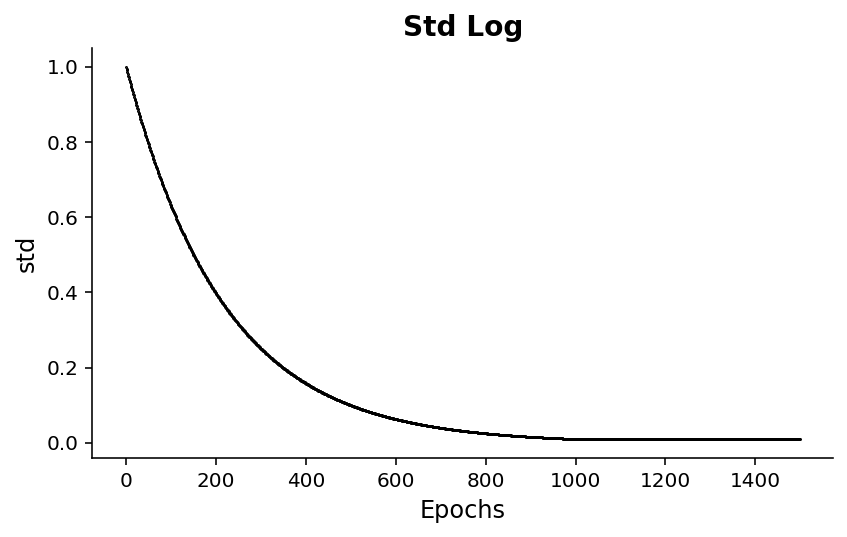

<Figure size 432x288 with 0 Axes>

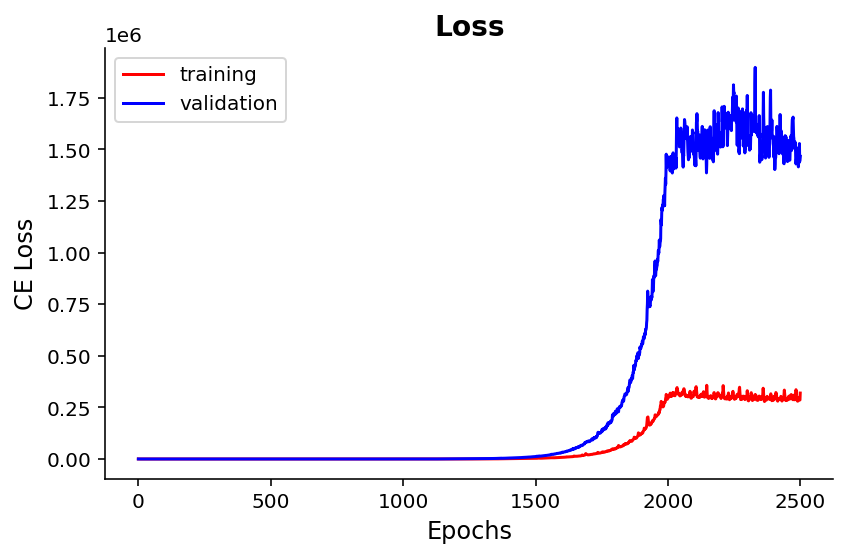

<Figure size 432x288 with 0 Axes>

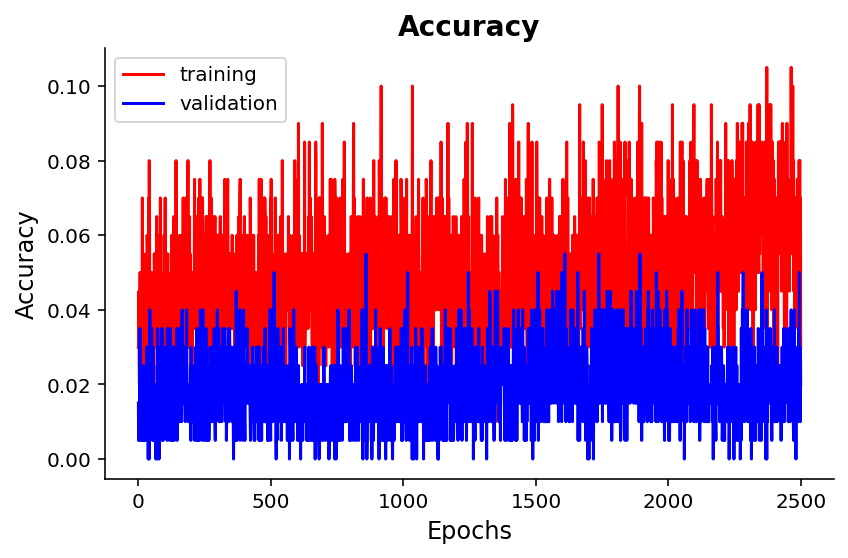

<Figure size 432x288 with 0 Axes>

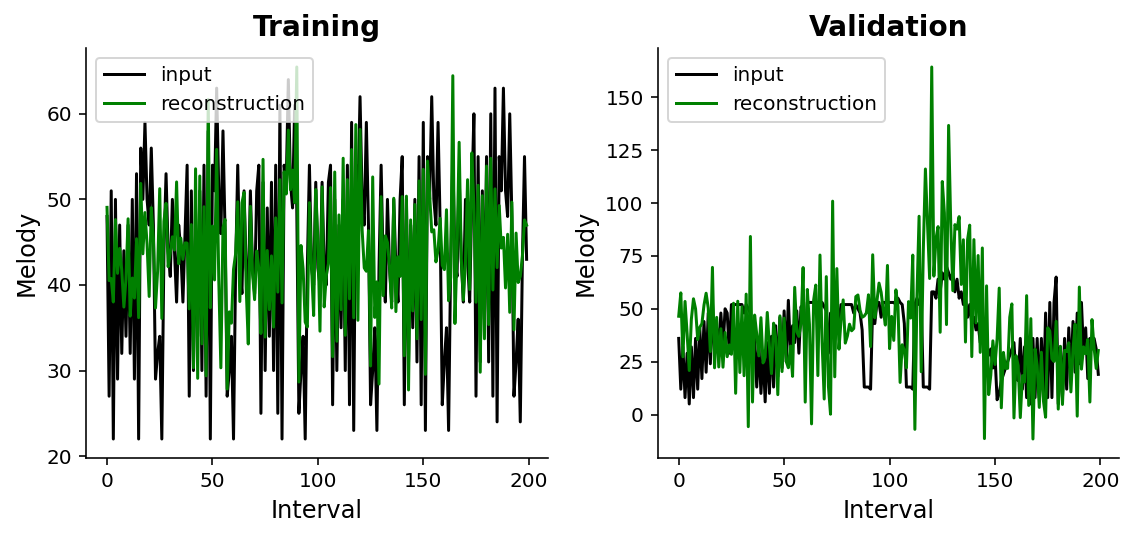

<Figure size 432x288 with 0 Axes>

In [15]:
### ===== Train Model Using first MSE then CE ===== ###

model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    stdlog = np.append(np.geomspace(1, 0.01, 1000), np.ones(500)*0.01)
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name1+'_CE2',
                   X_train_melody, X_val_melody,
                   learning_rate, [seed_load, seed_model], 1500,
                   eepoch=100,
                   lda0=0, lda1=1, lda2=1,
                   stdlog=stdlog,
                   train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                   save=True, load=True, mdl_load= mdl_name1+'_MSE')
    
    vis.plot_stdlog(stdlog, './figures/{}_CE2_stdlog.png'.format(mdl_name1))
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/{}_CE2_loss.png'.format(mdl_name1), ylabel='CE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/{}_CE2_acc.png'.format(mdl_name1), ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train_melody[0], X_val_melody[0], './figures/{}_CE2_sample.png'.format(mdl_name1))
    
except KeyboardInterrupt:
    print('Training terminated.')

## Training Note Offsets

Epoch: 0	 TLoss: 423.923087	 VLoss: 616.303448	 TACC: 0.07	 VACC: 0.02
Epoch: 100	 TLoss: 159.919589	 VLoss: 214.719519	 TACC: 0.04	 VACC: 0.07
Epoch: 200	 TLoss: 155.198438	 VLoss: 201.583997	 TACC: 0.04	 VACC: 0.04
Epoch: 300	 TLoss: 154.854678	 VLoss: 194.136220	 TACC: 0.04	 VACC: 0.06
Epoch: 400	 TLoss: 156.242046	 VLoss: 191.308081	 TACC: 0.04	 VACC: 0.06
Epoch: 500	 TLoss: 156.096584	 VLoss: 190.243063	 TACC: 0.04	 VACC: 0.05
Epoch: 600	 TLoss: 153.746411	 VLoss: 192.812837	 TACC: 0.04	 VACC: 0.06
Epoch: 700	 TLoss: 155.129944	 VLoss: 190.899519	 TACC: 0.04	 VACC: 0.06
Epoch: 800	 TLoss: 154.900116	 VLoss: 190.699162	 TACC: 0.04	 VACC: 0.05
Epoch: 900	 TLoss: 155.081376	 VLoss: 188.004603	 TACC: 0.04	 VACC: 0.06


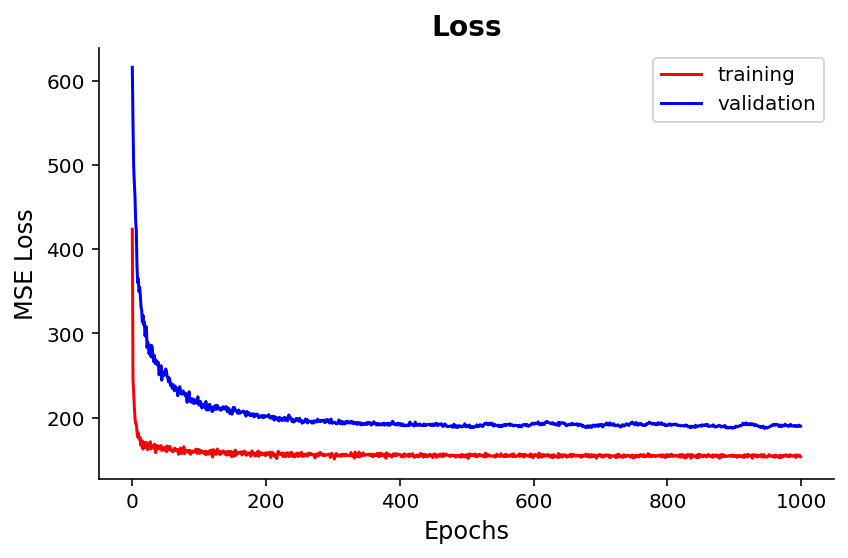

<Figure size 432x288 with 0 Axes>

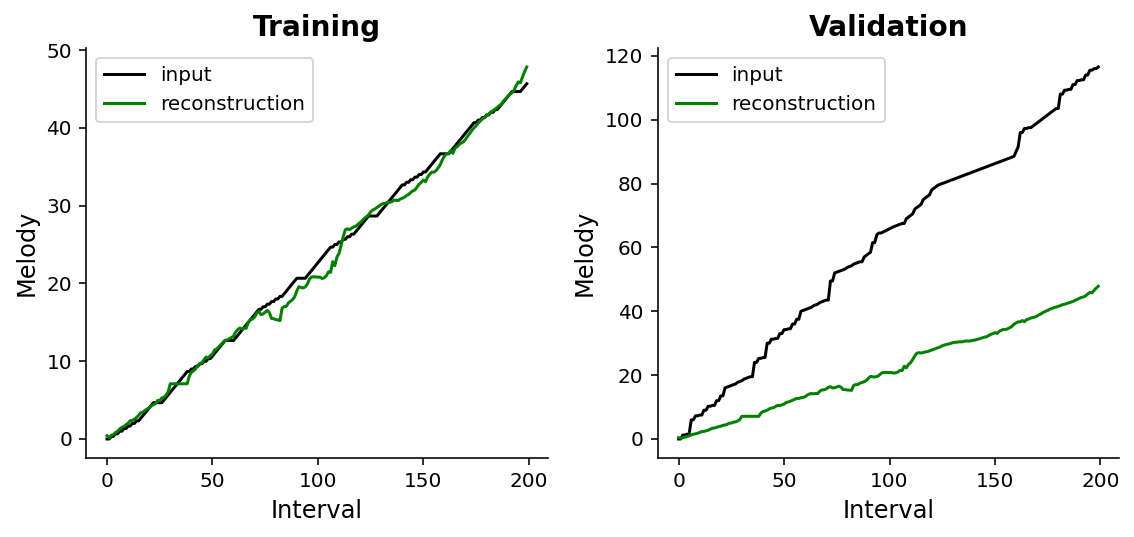

<Figure size 432x288 with 0 Axes>

In [5]:
### ===== Train Model for Offset using MSELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    model_off1, train_losses_off1, val_losses_off1, _, _ = train_model(model, device, mdl_name2+'_center',
                                                                       X_train_offset, X_val_offset,
                                                                       learning_rate, [seed_load, seed_model], 1000,
                                                                       eepoch=100,
                                                                       lda0=1, lda1=0, lda2=1,
                                                                       train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                                                                       save=True, load=False)
except KeyboardInterrupt:
    print('Training terminated.')
    
vis.plot_train_val_loss(train_losses_off1, val_losses_off1, './figures/{}_center.png'.format(mdl_name2), ylabel='MSE Loss')
_ = vis.plot_train_val_sample(model_off1, X_train_offset[0], X_val_offset[0], './figures/{}_center_sample.png'.format(mdl_name2))

In [7]:
### ===== Data Preprocessing ===== ###

_, _, X_train_offset, X_val_offset = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load, process='difference')
X_train_offset, X_val_offset = pcr.batchify(X_train_offset), pcr.batchify(X_val_offset)
Corpus2, fmap2, rmap2 = pcr.get_map_offset(X_train_offset)
X_train_offset = pcr.fmap_offset(X_train_offset, fmap2, song_len)
X_val_offset = pcr.fmap_offset(X_val_offset, fmap2, song_len)

Epoch: 0	 TLoss: 12.301119	 VLoss: 14.105666	 TACC: 0.20	 VACC: 0.17
Epoch: 100	 TLoss: 9.917751	 VLoss: 10.886548	 TACC: 0.20	 VACC: 0.17
Epoch: 200	 TLoss: 9.880518	 VLoss: 9.899995	 TACC: 0.19	 VACC: 0.30
Epoch: 300	 TLoss: 9.859176	 VLoss: 9.810969	 TACC: 0.23	 VACC: 0.36
Epoch: 400	 TLoss: 9.854307	 VLoss: 9.374188	 TACC: 0.20	 VACC: 0.33
Epoch: 500	 TLoss: 9.860789	 VLoss: 9.355980	 TACC: 0.18	 VACC: 0.35
Epoch: 600	 TLoss: 9.861961	 VLoss: 9.353977	 TACC: 0.17	 VACC: 0.32
Epoch: 700	 TLoss: 9.851430	 VLoss: 9.350947	 TACC: 0.20	 VACC: 0.30
Epoch: 800	 TLoss: 9.851694	 VLoss: 9.339900	 TACC: 0.19	 VACC: 0.28
Epoch: 900	 TLoss: 9.837919	 VLoss: 9.340053	 TACC: 0.20	 VACC: 0.26


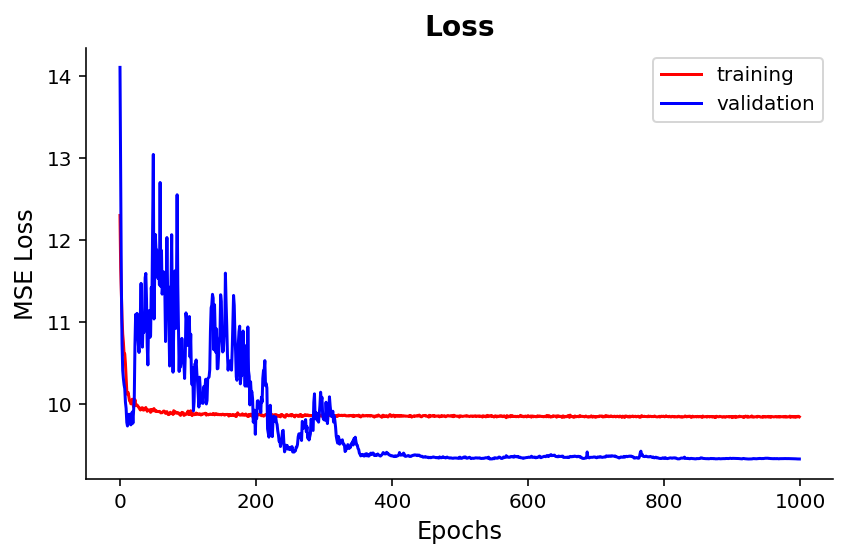

<Figure size 432x288 with 0 Axes>

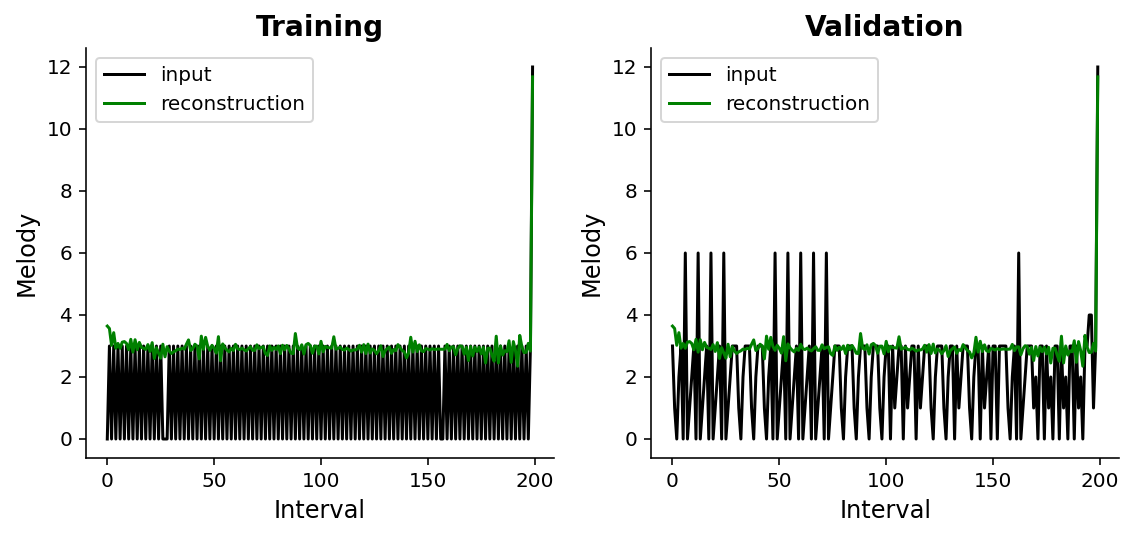

<Figure size 432x288 with 0 Axes>

In [8]:
### ===== Train Model for Offset (difference) using MSELoss ===== ###

seed_model = 527758681 
torch.manual_seed(seed_model)
model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    model.std = 0.1
    model_off2, train_losses_off2, val_losses_off2, _, _ = train_model(model, device, mdl_name2+'_diff',
                                                                       X_train_offset, X_val_offset,
                                                                       learning_rate, [seed_load, seed_model], 1000,
                                                                       eepoch=100,
                                                                       lda0=1, lda1=0, lda2=1,
                                                                       train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                                                                       save=True, load=False)
except KeyboardInterrupt:
    print('Training terminated.')
    
vis.plot_train_val_loss(train_losses_off2, val_losses_off2, './figures/{}_diff.png'.format(mdl_name2), ylabel='MSE Loss')
_ = vis.plot_train_val_sample(model_off2, X_train_offset[0], X_val_offset[0], './figures/{}_diff_sample.png'.format(mdl_name2))

Epoch: 0	 TLoss: 464.161335	 VLoss: 447.514728	 TACC: 0.00	 VACC: 0.27
Epoch: 100	 TLoss: 194.483920	 VLoss: 512.141003	 TACC: 0.27	 VACC: 0.20
Epoch: 200	 TLoss: 168.677078	 VLoss: 581.129269	 TACC: 0.27	 VACC: 0.16
Epoch: 300	 TLoss: 154.338668	 VLoss: 614.402404	 TACC: 0.30	 VACC: 0.20
Epoch: 400	 TLoss: 154.463275	 VLoss: 692.121325	 TACC: 0.29	 VACC: 0.20
Epoch: 500	 TLoss: 150.802844	 VLoss: 873.846895	 TACC: 0.28	 VACC: 0.15
Epoch: 600	 TLoss: 145.270242	 VLoss: 1034.268294	 TACC: 0.26	 VACC: 0.18
Epoch: 700	 TLoss: 149.249397	 VLoss: 1194.222358	 TACC: 0.27	 VACC: 0.15
Epoch: 800	 TLoss: 147.177777	 VLoss: 1082.157913	 TACC: 0.28	 VACC: 0.17
Epoch: 900	 TLoss: 153.959493	 VLoss: 934.806727	 TACC: 0.31	 VACC: 0.20


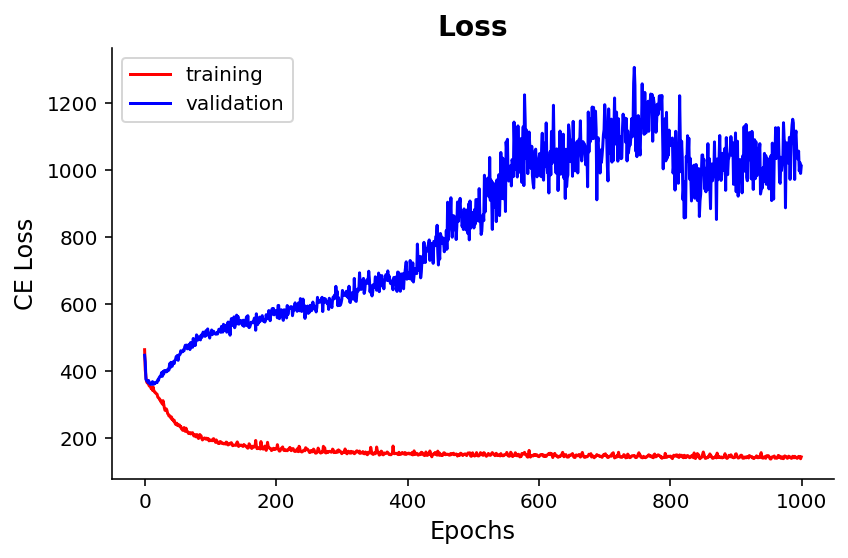

<Figure size 432x288 with 0 Axes>

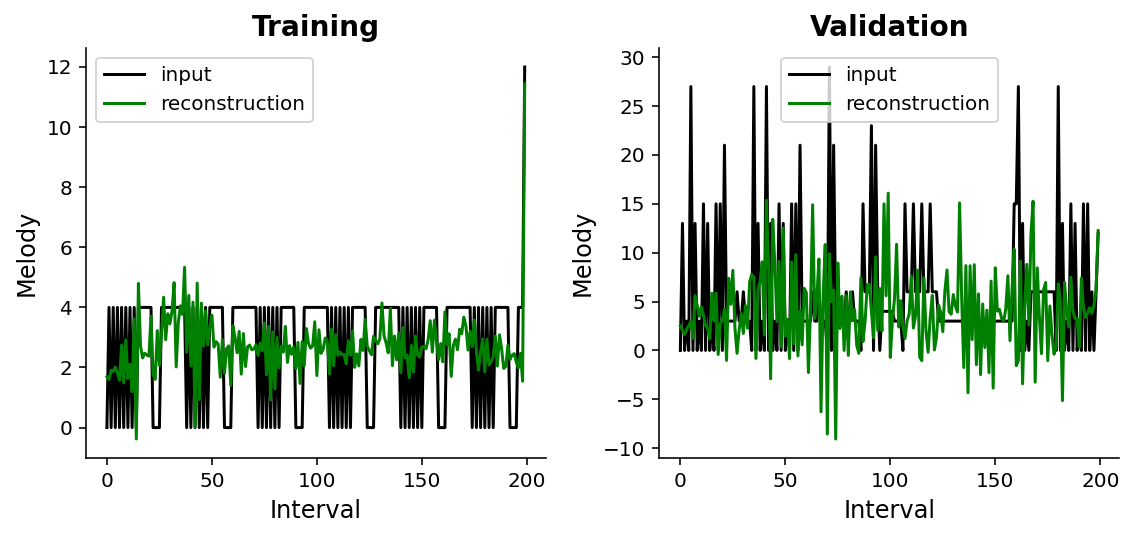

<Figure size 432x288 with 0 Axes>

In [8]:
### ===== Train Model for Offset (difference) using CELoss ===== ###

torch.manual_seed(seed_model)
model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    model.std = 0.1
    model_off3, train_losses_off3, val_losses_off3, _, _ = train_model(model, device, mdl_name2+'_diff_CE',
                                                                       X_train_offset, X_val_offset,
                                                                       learning_rate, [seed_load, seed_model], 1000,
                                                                       eepoch=100,
                                                                       lda0=0, lda1=1, lda2=1,
                                                                       train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                                                                       save=True, load=False)
except KeyboardInterrupt:
    print('Training terminated.')
    
vis.plot_train_val_loss(train_losses_off3, val_losses_off3, './figures/{}_diff_CEloss.png'.format(mdl_name2), ylabel='CE Loss')
_ = vis.plot_train_val_sample(model_off3, X_train_offset[0], X_val_offset[0], './figures/{}_diff_CE_sample.png'.format(mdl_name2))